Option is a financial contract that gives the owner the right, but not the obligation, to buy or sell a specific stock at a predetermined price (strike price) within a specified time frame. Both call and put options can be bought and sold on stock exchanges, providing investors with the ability to speculate on the direction of stock prices.</b>

Similar to stock prices which are determined by supply and demand in the stock market, options price are determined by the desirability to buy or sell stocks at the strike price given market conditions. For example, as the price of the underlying asset increases, the price of a call option increases, while the price of a put option decreases. </b>

In this notebook, we explore how different factors affect the price of put and call options. We first build some code to calculate price of call and put options using Black Scholes Model and Monte Carlos Simulation. We then make changes to the following factors to see its impacts on price of call and put options: </b>

<li> price of underlying assets </li>
<li> strike price </li>
<li> time to maturity </li>
<li> volatility of stock </li>
<li> risk-free interest rate </li>

In [16]:
# Import Library

In [5]:
#install yfinance if not done already to fetch stock price
#!pip install yfinance

import pandas as pd
import numpy as np
import matplotlib as plt
import yfinance as yf
from scipy.stats import norm 
import matplotlib.pyplot as plt

# Script to get the price of call and put

In [7]:
class GetStockData:
    """Class for fetcing data from yahoo finance."""
    
    @staticmethod
    def get_historical_data(ticker, start_date=None, end_date=None):
        """
        Fetches stock data from yahoo finance. 
        
        Params:
        ticker: ticker symbol
        start_date: start date for historical data
        end_date: end date for historical data
        """
        
        ticker_data = yf.Ticker(ticker)

        #get the historical prices for this ticker
        data = ticker_data.history(period='1d', start=start_date, end=end_date)
    
    @staticmethod
    def get_last_price(data, column_name):
        """
        Returns last available price for specified column from already fetched data.
        
        Params:
        data: dataframe representing fetched data
        column_name: name of the column in dataframe
        """
        if data is None or column_name is None:
            return None
        if column_name not in list(data.columns):
            return None
        return data[column_name].iloc[len(data) - 1]
    
from enum import Enum
from abc import ABC, abstractclassmethod

class OPTION_TYPE(Enum):
    CALL_OPTION = 'Call Option'
    PUT_OPTION = 'Put Option'

class OptionPricingModel(ABC):
    """Abstract class defining interface for option pricing models."""

    def calculate_option_price(self, option_type):
        """Calculates call/put option price according to the specified parameter."""
        if option_type == OPTION_TYPE.CALL_OPTION.value:
            return self._calculate_call_option_price()
        elif option_type == OPTION_TYPE.PUT_OPTION.value:
            return self._calculate_put_option_price()
        else:
            return -1

    @abstractclassmethod
    def _calculate_call_option_price(self):
        """Calculates option price for call option."""
        pass

    @abstractclassmethod
    def _calculate_put_option_price(self):
        """Calculates option price for put option."""
        pass

# Local package imports
#from .base import OptionPricingModel

class BlackScholesModel(OptionPricingModel):
    """ 
    Class implementing calculation for European option price using Black-Scholes Formula.
    Call/Put option price is calculated with following assumptions:
    - European option can be exercised only on maturity date.
    - Underlying stock does not pay divident during option's lifetime.  
    - The risk free rate and volatility are constant.
    - Efficient Market Hypothesis - market movements cannot be predicted.
    - Lognormal distribution of underlying returns.
    """

    def __init__(self, 
                 underlying_spot_price, 
                 strike_price, 
                 days_to_maturity, 
                 risk_free_rate, 
                 sigma):
        """
        Initializes variables used in Black-Scholes formula .
        underlying_spot_price: current stock or other underlying spot price
        strike_price: strike price for option cotract
        days_to_maturity: option contract maturity/exercise date
        risk_free_rate: returns on risk-free assets (assumed to be constant until expiry date)
        sigma: volatility of the underlying asset (standard deviation of asset's log returns)
        """
        self.S = underlying_spot_price
        self.K = strike_price
        self.T = days_to_maturity / 365
        self.r = risk_free_rate
        self.sigma = sigma
        
    def _calculate_call_option_price(self): 
        """
        Calculates price for call option according to the formula.        
        Formula: S*N(d1) - PresentValue(K)*N(d2)
        """
        # cumulative function of standard normal distribution (risk-adjusted probability that the option will be exercised)     
        d1 = (np.log(self.S / self.K) + (self.r + 0.5 * self.sigma ** 2) * self.T) / (self.sigma * np.sqrt(self.T))
        
        # cumulative function of standard normal distribution (probability of receiving the stock at expiration of the option)
        d2 = (np.log(self.S / self.K) + (self.r - 0.5 * self.sigma ** 2) * self.T) / (self.sigma * np.sqrt(self.T))
        
        return (self.S * norm.cdf(d1, 0.0, 1.0) - self.K * np.exp(-self.r * self.T) * norm.cdf(d2, 0.0, 1.0))
    

    def _calculate_put_option_price(self): 
        """
        Calculates price for put option according to the formula.        
        Formula: PresentValue(K)*N(-d2) - S*N(-d1)
        """  
        # cumulative function of standard normal distribution (risk-adjusted probability that the option will be exercised)    
        d1 = (np.log(self.S / self.K) + (self.r + 0.5 * self.sigma ** 2) * self.T) / (self.sigma * np.sqrt(self.T))

        # cumulative function of standard normal distribution (probability of receiving the stock at expiration of the option)
        d2 = (np.log(self.S / self.K) + (self.r - 0.5 * self.sigma ** 2) * self.T) / (self.sigma * np.sqrt(self.T))
        
        return (self.K * np.exp(-self.r * self.T) * norm.cdf(-d2, 0.0, 1.0) - self.S * norm.cdf(-d1, 0.0, 1.0))
    
class MonteCarloPricing(OptionPricingModel):
    """ 
    Class implementing calculation for European option price using Monte Carlo Simulation.
    We simulate underlying asset price on expiry date using random stochastic process - Brownian motion.
    For the simulation generated prices at maturity, we calculate and sum up their payoffs, average them and discount the final value.
    That value represents option price
    """

    def __init__(self, 
                 underlying_spot_price, 
                 strike_price, 
                 days_to_maturity, 
                 risk_free_rate, 
                 sigma, 
                 number_of_simulations):
        """
        Initializes variables used in Black-Scholes formula .
        underlying_spot_price: current stock or other underlying spot price
        strike_price: strike price for option cotract
        days_to_maturity: option contract maturity/exercise date
        risk_free_rate: returns on risk-free assets (assumed to be constant until expiry date)
        sigma: volatility of the underlying asset (standard deviation of asset's log returns)
        number_of_simulations: number of potential random underlying price movements 
        """
        # Parameters for Brownian process
        self.S_0 = underlying_spot_price
        self.K = strike_price
        self.T = days_to_maturity / 365
        self.r = risk_free_rate
        self.sigma = sigma 
        
        # Parameters for simulation
        self.N = number_of_simulations
        self.num_of_steps = days_to_maturity
        self.dt = self.T / self.num_of_steps

    def simulate_prices(self):
        """
        Simulating price movement of underlying prices using Brownian random process.
        Saving random results.
        """
        np.random.seed(20)
        self.simulation_results = None

        # Initializing price movements for simulation: rows as time index and columns as different random price movements.
        S = np.zeros((self.num_of_steps, self.N))        
        # Starting value for all price movements is the current spot price
        S[0] = self.S_0

        for t in range(1, self.num_of_steps):
            # Random values to simulate Brownian motion (Gaussian distibution)
            Z = np.random.standard_normal(self.N)
            # Updating prices for next point in time 
            S[t] = S[t - 1] * np.exp((self.r - 0.5 * self.sigma ** 2) * self.dt + (self.sigma * np.sqrt(self.dt) * Z))

        self.simulation_results_S = S

    def _calculate_call_option_price(self): 
        """
        Call option price calculation. Calculating payoffs for simulated prices at expiry date, summing up, averiging them and discounting.   
        Call option payoff (it's exercised only if the price at expiry date is higher than a strike price): max(S_t - K, 0)
        """
        if self.simulation_results_S is None:
            return -1
        return np.exp(-self.r * self.T) * 1 / self.N * np.sum(np.maximum(self.simulation_results_S[-1] - self.K, 0))
 
    def _calculate_put_option_price(self): 
        """
        Put option price calculation. Calculating payoffs for simulated prices at expiry date, summing up, averiging them and discounting.   
        Put option payoff (it's exercised only if the price at expiry date is lower than a strike price): max(K - S_t, 0)
        """
        if self.simulation_results_S is None:
            return -1
        return np.exp(-self.r * self.T) * 1 / self.N * np.sum(np.maximum(self.K - self.simulation_results_S[-1], 0))

# Case Study: Tesla Options (TSLA)

In [7]:
# Fetching the prices from yahoo finance
data = GetStockData.get_historical_data('TSLA','2021-01-01','2022-01-01')
last_closing_price = GetStockData.get_last_price(data, 'Close')


### Price of Underlying Asset

How does the change in TSLA price affect call and put options? In this example, we tried a few simulations to see how the options price changes if TSLA price drop 20%, drop 10%, stay the same, rise 10% or rise 20%?

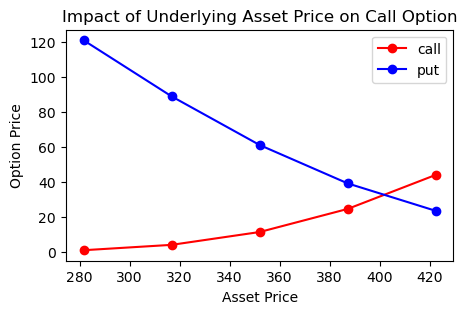

In [17]:

last_closing_price = 352
percentages_change = np.array([-20,-10,0,10, 20])
prices = last_closing_price * (1 + percentages_change/100)
strike_price = last_closing_price*1.2

call = []
put = []
for price in prices:
    BSM = BlackScholesModel(price, strike_price, 365, 0.05, 0.2)
    call_option = BSM.calculate_option_price('Call Option')
    put_option = BSM.calculate_option_price('Put Option')
    call.append(call_option)
    put.append(put_option)

#visualise the impact
plt.figure(figsize=(5,3))
plt.plot(prices,call,'-o',color='red',label='call')
plt.plot(prices,put,'-o',color='blue',label='put')
plt.title('Impact of Underlying Asset Price on Call Option')
plt.xlabel('Asset Price')
plt.ylabel('Option Price')
plt.legend()
plt.show()

As asset price go up, call option increase in price while put option decrease in price because investors would want to purchase assets at the locked-in strike price.

## Strike Price

In [ ]:
How does the change in strike price affect call and put options? 

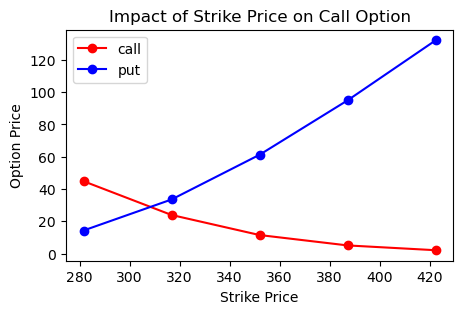

In [21]:

last_closing_price = 352
percentages_change = np.array([-20,-10,0,10, 20])
strike_price = last_closing_price*1.2
strike_prices = strike_price * (1 + percentages_change/100)


call = []
put = []
for price in strike_prices:
    BSM = BlackScholesModel(last_closing_price, price, 365, 0.05, 0.2)
    call_option = BSM.calculate_option_price('Call Option')
    put_option = BSM.calculate_option_price('Put Option')
    call.append(call_option)
    put.append(put_option)

#visualise the impact
plt.figure(figsize=(5,3))
plt.plot(prices,call,'-o',color='red',label='call')
plt.plot(prices,put,'-o',color='blue',label='put')
plt.title('Impact of Strike Price on Call Option')
plt.xlabel('Strike Price')
plt.ylabel('Option Price')
plt.legend()
plt.show()

In reverse from underlying asset price, as strike price go up, call option increase in price while put option decrease in price because investors would want to purchase assets at the locked-in strike price.

### Time to Maturity

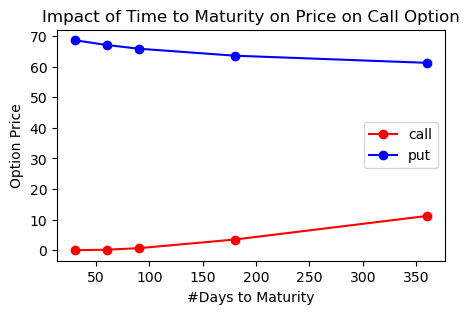

In [38]:
#if strike price is above market price

last_closing_price = 352
strike_price = last_closing_price*1.2
ndays_to_maturity = [30,60,90,180,360]

call = []
put = []
for n in ndays_to_maturity:
    BSM = BlackScholesModel(last_closing_price, strike_price, n, 0.05, 0.2)
    call_option = BSM.calculate_option_price('Call Option')
    put_option = BSM.calculate_option_price('Put Option')
    call.append(call_option)
    put.append(put_option)

#visualise the impact
plt.figure(figsize=(5,3))
plt.plot(ndays_to_maturity,call,'-o',color='red',label='call')
plt.plot(ndays_to_maturity,put,'-o',color='blue',label='put')
plt.title('Impact of Time to Maturity on Price on Call Option')
plt.xlabel('#Days to Maturity')
plt.ylabel('Option Price')
plt.legend()
plt.show()

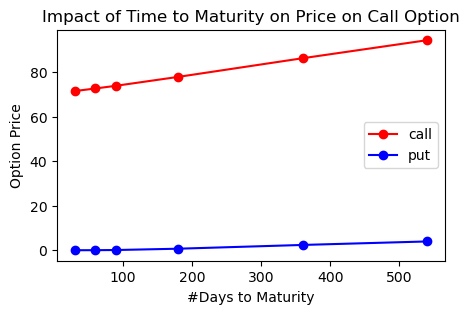

In [40]:
#if strike price is below market price

last_closing_price = 352
strike_price = last_closing_price*0.8
ndays_to_maturity = [30,60,90,180,360,540]

call = []
put = []
for n in ndays_to_maturity:
    BSM = BlackScholesModel(last_closing_price, strike_price, n, 0.05, 0.2)
    call_option = BSM.calculate_option_price('Call Option')
    put_option = BSM.calculate_option_price('Put Option')
    call.append(call_option)
    put.append(put_option)

#visualise the impact
plt.figure(figsize=(5,3))
plt.plot(ndays_to_maturity,call,'-o',color='red',label='call')
plt.plot(ndays_to_maturity,put,'-o',color='blue',label='put')
plt.title('Impact of Time to Maturity on Price on Call Option')
plt.xlabel('#Days to Maturity')
plt.ylabel('Option Price')
plt.legend()
plt.show()

The more time you have until the expiration date, the more valuable the option should be. However it is not always the case. The situation is more complicated when the option is not ATM. For example, an in-the-money put option with no dividend may see its value decrease with increasing time to expiry due to its value being driven by its intrinsic value whose present-value declines, rather than increases with increasing time. 

### Volatility

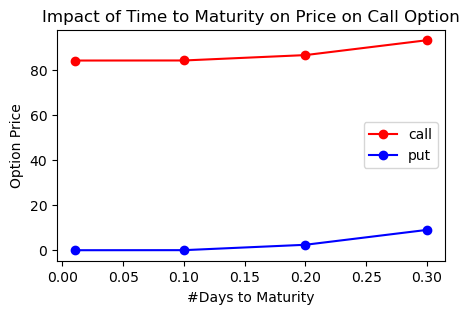

In [42]:


last_closing_price = 352
strike_price = last_closing_price*0.8
sigma_range = [0.01,0.1,0.2,0.3]

call = []
put = []
for sigma in sigma_range:
    BSM = BlackScholesModel(last_closing_price, strike_price, 365, 0.05, sigma)
    call_option = BSM.calculate_option_price('Call Option')
    put_option = BSM.calculate_option_price('Put Option')
    call.append(call_option)
    put.append(put_option)

#visualise the impact
plt.figure(figsize=(5,3))
plt.plot(sigma_range,call,'-o',color='red',label='call')
plt.plot(sigma_range,put,'-o',color='blue',label='put')
plt.title('Impact of Time to Maturity on Price on Call Option')
plt.xlabel('#Days to Maturity')
plt.ylabel('Option Price')
plt.legend()

As volatility increase, option prices increase as investors have bigger potential payoff from exercising options.

### Risk-Free Interest Rate

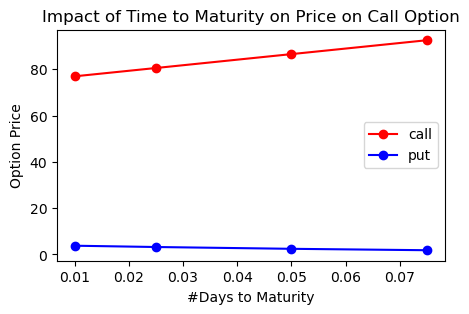

In [43]:
last_closing_price = 352
strike_price = last_closing_price*0.8
interest_rate_range = [0.01,0.025,0.05,0.075]

call = []
put = []
for interest_rate in interest_rate_range:
    BSM = BlackScholesModel(last_closing_price, strike_price, 365, interest_rate,0.2)
    call_option = BSM.calculate_option_price('Call Option')
    put_option = BSM.calculate_option_price('Put Option')
    call.append(call_option)
    put.append(put_option)

#visualise the impact
plt.figure(figsize=(5,3))
plt.plot(interest_rate_range,call,'-o',color='red',label='call')
plt.plot(interest_rate_range,put,'-o',color='blue',label='put')
plt.title('Impact of Time to Maturity on Price on Call Option')
plt.xlabel('#Days to Maturity')
plt.ylabel('Option Price')
plt.legend()

As interest rates increase, the present value of the potential future cash flows from the underlying asset decreases. This affects the price of call and put options, as they are based on the future price of the underlying asset. For a call option, the potential future cash flows increase as the underlying asset price increases, and so an increase in interest rates reduces the value of the option. Conversely, for a put option, the potential future cash flows increase as the underlying asset price decreases, and so an increase in interest rates increases the value of the option.